In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmath import pi,acos,exp,sqrt
def plotArc(ax,P0,n0,l,da,*args,tol=0.001,**kwargs):
  if l==0:
    return
  x=np.linspace(0,l,max(2,int(abs(6*(da/(2*pi)))),int(l//(2*abs(2*l/da*tol)**0.5)+1))if (da!=0) and (l!=0) else 2)
  phi2=x/l*da/2
  p=P0+x*np.sinc(phi2/pi)*n0*np.exp(1j*phi2)
  ax.plot(p.real,p.imag,*args,**kwargs)
    
def plotArcchain(ax,P0,n0,arcs,*args,**kwargs):
    p=P0
    n=n0
    for l,da in arcs:
        plotArc(ax,p,n,l,da,*args,**kwargs)
        p+=l*np.sinc(da/(2*pi))*n*exp(1j*da/2)
        n*=exp(1j*da)



In [2]:
class partial:
  __slots__=('args', 'func', 'keywords')
  def __init__(self,f,*args,**kwargs):
    self.func=f
    self.args=args
    self.keywords=kwargs
  def __call__(self,*args,**kwargs):
    return self.func(*self.args,*args,**(self.keywords|kwargs))
#try:
#  from functools import partial
#except ImportError:
#  pass
    
class pipe(partial):
  def __ror__(self,other):
    return self(other)
      
class iterable(partial):
  def __iter__(self):
    return self()
class iterable(partial):
  def __new__(cls,fgen):
    if hasattr(fgen,'__iter__') and hasattr(fgen,'__add__') and hasattr(fgen,'__mul__'):
      return fgen
    return super().__new__(cls,fgen)
  def __iter__(self):
    return self()
  def __add__(self,other):
    return iterable(lambda:(v for g in (self,other) for v in g))
  def __mul__(self,other):
    return iterable(lambda:(v for _ in range(other) for g in (self) for v in g))
    

In [3]:
#from functools import reduce
def reduce(function, iterable, initializer=None):
    it = iter(iterable)
    if initializer is None:
        value = next(it)
    else:
        value = initializer
    for element in it:
        value = function(value, element)
    return value

In [4]:
from itertools import takewhile

#from bisect import bisect_right
def bisect_right(a,x,lo=0,hi=None):
    if hi is None:
        hi = len(a)
    while lo < hi:
        mid = (lo + hi) // 2
        if x < a[mid]:
            hi = mid
        else:
            lo = mid + 1
    return lo

def index_frac(x,ax):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return idx-1,(x-ax[idx-1])/(ax[idx]-ax[idx-1])
    
def interp(x,ax,ay):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return ay[idx-1]+(x-ax[idx-1])/(ax[idx]-ax[idx-1])*(ay[idx]-ay[idx-1])

def cumsum(x,x_start=None):
    if x_start!=None:
        csum=[x_start]+x.copy()
    else:
        csum=x.copy()
    for i in range(1,len(csum)):
        csum[i]+=csum[i-1]
    return csum


In [5]:
#interpSegments, Segments2Complex
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign,inf

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLength(Segs):
    return sum(l for l,*_ in Segs)

def SegmentsArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in Segs]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t)
  T=t.astype(int)
#  t=t-T
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/nsinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1]*a0,ang_[-1],T)
  pr+=p0
  ar*=a0
  l=L/L[-1]
  Xx=np.interp(t-T,l,range(len(l)))
  X=np.maximum(0,np.minimum(Xx.astype(int),len(dang)-1)) #segment index
  x=Xx-X#within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  a=ang[X]*np.exp(1j*dang[X]*x)*ar
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
      a=a[0]
  return p,a,L[-1]*t,X

def Segments2Complex(Segs,p0=0.+0.j,a0=1,scale=1.0,tol=0.05,offs=0,loops=1,return_start=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  L=0
  if return_start:
      yield p,a,L,-1 #assuming closed loop: start-point = end-point
  loopcount=0
  while (loops==None) or (loops==inf) or (loopcount<loops):
      loopcount+=1
      for X,(l,da,*_) in enumerate(Segs):
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for i in range(n):
          L+=l/n
          p+=v
          yield p,a,L,X
          v*=dda
          a*=dda


In [6]:
def subdivide(l,maxdl=None,pc=0,r=None):
    """ 
    Add points to all line segments that intersect a circle with radius `r` around the center point `pc` 
    until no line segment in this region is longer than `maxdl`.
    
    Arguments: 
    l:complex   = iterable list of points that define the path
    maxdl:float = maximum length of a line segment => insert points if a line segment is longer
    pc:complex  = center point of circle  
    r:float     = radius of circle that defines the affected region
    
    Result: 
    <generator>:complex = generator that returns all original points, plus additional interpolated points 
                          in the specified circular region around `pc`.
    """
    if maxdl==None:
        yield from l
        return
    l_start=next(l)
    for l_end in l:
        yield l_start
        dl=l_end-l_start
        absdl=abs(dl)
        if absdl<maxdl:
            l_start=l_end
            continue #no need to calculate anything else
        edl=dl/absdl
        x0=0
        x1=absdl 
        if r!=None:
          rr=(pc-l_start)/edl
          if (abs(rr.imag)<r): 
              dx=(r*r-rr.imag*rr.imag)**0.5
              x0=max(rr.real-dx,x0)
              x1=min(rr.real+dx,x1)
          else:
              x1=-1 #circle does not intersect
        if x1>x0:
          dx=x1-x0
          n=int(dx//maxdl)+1
          ddx=(dx/n)*edl
          x=x0*edl+l_start
          if x0>0:
            yield x  
          for _ in range(1,n):
            x+=ddx
            yield x
          if x1<absdl:
            yield x1*edl+l_start
        l_start=l_end
    yield l_start
tenderize=subdivide

In [7]:
def radial_expand(l,pc,ro,ri=0):
    """
    Clear a circle by pushing the points outward, away from the center point `pc`.
    
    Arguments: 
    l:complex  = iterable list of points
    pc:complex = center point of circle  
    ro:float   = radius of circle that defines the affected points
    ri:float   = radius of circle that is cleared by pushing the points towards `ro`
    
    Result: 
    <generator>:complex = generator that returns the transformed points
    """
    for p in l:
        r=p-pc
        absr=abs(r)
        if absr<ro:
            p=pc+r/absr*((ri+(ro-ri)*absr/ro))
        yield p
pierce=radial_expand

[(4.067807680070515, 1.5627647869234897)]

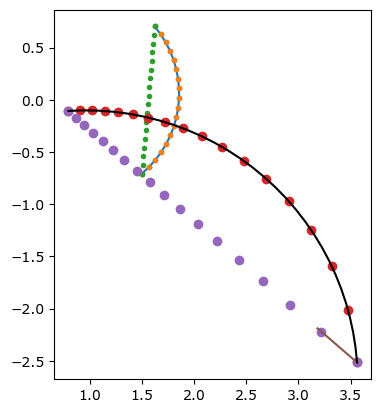

In [8]:
# Möbius
p0=1.5-1j*sqrt(0.5)
a0= 1j**(40/90)
r=1
phi=pi/2
arc=(p0,a0,r*phi,phi)
arcchain=([[r*phi,phi]],p0,a0)
          
phi_i=np.linspace(0,phi,18)
P=p0-a0*1j*(r*1j**(phi_i/(0.5*pi))-r)
F_m=lambda a,b,c,d,z:(a*z+b)/(c*z+d)
dFdz_m=lambda a,b,c,d,z:(a*d - b*c)/(c*z + d)**2

T_m=lambda p,q,rphi,z:(p*q*(rphi - 1) + z*(p - q*rphi))/(p*rphi - q + z*(1 - rphi))
dTdz_m=lambda p,q,rphi,z:rphi*((p - q)/(p*rphi - q + z*(1-rphi)))**2
p=-2
q=2
rphi=0.5*1j**(-80/90)
P_m=T_m(p,q,rphi,P)
plotArc(plt,*arc,'.-')
plt.plot(P.real,P.imag,'.')
Pchord=np.linspace(P[0],P[-1],18)
plt.plot(Pchord.real,Pchord.imag,'.') 
plt.plot(P_m.real,P_m.imag,'o')
Pchord_m=T_m(p,q,rphi,Pchord)
plt.plot(Pchord_m.real,Pchord_m.imag,'o')
plt.gca().set_aspect('equal')
dl=Pchord[-1]-Pchord[0] 
dl_T=Pchord_m[-1]-Pchord_m[0]
e0=(dl)*dTdz_m(p,q,rphi,Pchord[0])
e0/=abs(e0)  
dphi_m=e0/dl_T
dphi_m/=abs(dphi_m)
Pe0=Pchord_m[0]+0.5*e0
plt.plot((Pchord_m[0].real,Pe0.real),(Pchord_m[0].imag,Pe0.imag),'-')
def transformArcs(arcs,p_start=0,a_start=1,p=-1,q=1,rphi=1):
    from math import sin,atan2
    def sinc(x):
      if x==0:
          return 1.0
      return sin(x)/x
    p_start_T=T_m(p,q,rphi,p_start)
    dPdz_start=dTdz_m(p,q,rphi,p_start)
    a_start_T=a_start*dPdz_start
    a_start_T/=abs(a_start_T)
    def transform():
      P0=p_start
      a0=a_start
      P0_T=p_start_T
      dPdz0=dPdz_start
      for l,da,*extras in arcs:
        dl=l*sinc(0.5*da)
        e_chord=a0*1j**(da/pi) 
        e_chord/=abs(e_chord)
        dl*=e_chord
        P1=P0+dl
        P1_m=T_m(p,q,rphi,P1)
        dl_T=P1_m-P0_T
        edl_T=dl_T/abs(dl_T)
        a0_T=a0*dPdz0
        a0_T/=abs(a0_T)
        eda_T=edl_T/a0_T
        da_T=2*atan2(eda_T.imag,eda_T.real)
        l_T=abs(dl_T)/sinc(0.5*da_T)
        yield l_T,da_T,*extras
        P0=P1
        P0_T=T_m(p,q,rphi,P0)
        dPdz0=dTdz_m(p,q,rphi,P0)
        a0=a0*1j**(2*da/pi)
          
    return iterable(transform),p_start_T,a_start_T
tarc,tp0,ta0=transformArcs(*arcchain,p,q,rphi)
for tl,tda in tarc:
  plotArc(plt,tp0,ta0,tl,tda,'k')
list(tarc)

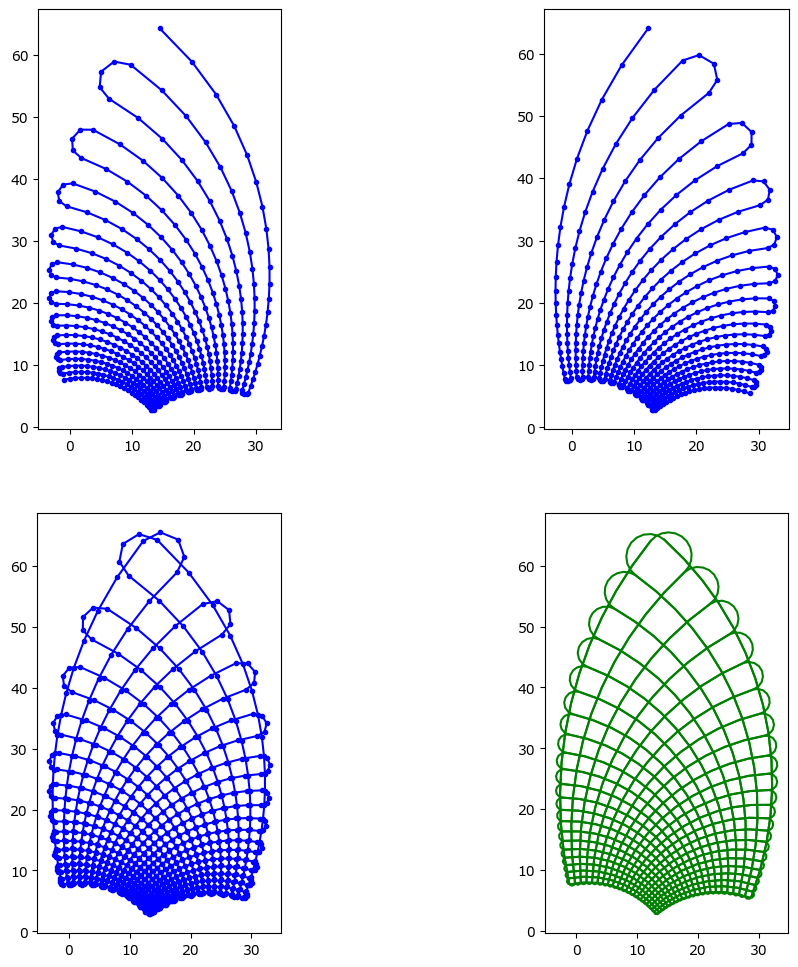

In [10]:
arcs=[[20.6,0],[0.5*pi,pi]]
arcs+=[[l,-da] for l,da in arcs] 
arcs*=11
p0=-10.3-10.5j
a0=1
pc1=2+3j
ro1=4
ri1=2.001
maxdl=1.0
pc2=-3-6j
ri2=1.5
ro2=3.0
pc,ri,ro=pc1,ri1,ro1
ew=0.5
#point source:
S1=lambda phi=0,**kwargs:Segments2Complex(arcs[:-1],p0*1j**phi, a0*1j**phi,return_start=True,**kwargs)
paLX2p=pipe(lambda g,dzdL=0,X2ew=lambda X:ew,**kwargs:(p for p,a,L,X in g))
#Transformations:
T1=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=0.25*maxdl,pc=pc,r=0.3*ro)
T2=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=0.5*maxdl,pc=pc,r=0.4*ro)
T3=lambda g,maxdl=maxdl,pc=pc,ro=ro,**kwargs: tenderize(g,maxdl=maxdl,pc=pc,r=ro)
T4=lambda g,pc=pc,ri=ri,ro=ro,**kwargs: pierce(g,pc=pc,ri=ri,ro=ro)
T5=pipe(lambda g,A=1,n=1.1:(A*p**n for p in g))
T=lambda g,**kwargs:T4(T3(T2(T1(g,**kwargs),**kwargs),**kwargs),**kwargs)

hole=lambda x=0,y=0,r=0:pipe(T,pc=x+1j*y,ri=r,ro=2*r)
drill=lambda x=0,y=0,d=0: hole(x,y,0.5*d)

translate=lambda dx=0,dy=0:pipe(lambda offs,g:(p+offs for p in g),dx+1j*dy) 

scale=lambda a:pipe(lambda a,g:(a*p for p in g),a) 

conformal_map=lambda A=1,n=1:pipe(lambda A,n,g:(A*x**n for x in g),A,n)

moebius=lambda a,b,c,d:pipe(lambda a,b,c,d,g:((a*z+b)/(c*z+d) for z in g),a,b,c,d)#Möbius transformation
moebius_i=lambda a,b,c,d:moebius(d,-b,-c,a)

T_moebius=lambda p,q,r,phi:(lambda p,q,rphi:moebius(p-q*rphi,p*q*(rphi-1),1-rphi,rphi*p-q))(p,q,r*1j**(phi/90))
T_i_moebius=lambda p,q,r,phi:(lambda p,q,rphi:moebius_i(p-q*rphi,p*q*(rphi-1),1-rphi,rphi*p-q))(p,q,r*1j**(phi/90))

rotate=lambda x=0,y=0,ang=90:pipe(lambda pc,n,g:((p-pc)*1j**n+pc for p in g),x+1j*y,ang/90)

mirror_x=pipe(lambda g:(p.conjugate() for p in g))
mirror_y=pipe(lambda g:(-p.conjugate() for p in g))

Tp2xy=pipe(lambda g:([p.real,p.imag] for p in g))
fig,axs=plt.subplots(2,2,figsize=(12,12))
axs[1,1].set_aspect('equal')
for i,ax in enumerate([*axs[0],axs[1,0],axs[1,0]]) : 
  sourcepath=S1(phi=-i)
  transform=pipe(lambda source: \
               source \
               |paLX2p \
               |hole(x=pc1.real,y=pc1.imag,r=ri1) \
               |hole(x=pc2.real,y=pc2.imag,r=ri2) \
#               |pipe(lambda g:([p.real,p.imag] for p in g) )
                )
  path=sourcepath | transform
  transformations2=[
                   partial(tenderize,maxdl=1),
                   hole(x=pc1.real,y=pc1.imag,r=ri1),
                   hole(x=pc2.real,y=pc2.imag,r=ri2),
                   translate(dx=0,dy=12),
                   conformal_map(A=0.1*1j**-0.5,n=1.5),
                   translate(dx=0,dy=-11),
                   conformal_map(A=0.507*1j**0.48,n=1.5),
                   translate(dx=0.1,dy=9.05),
#                   moebius(1,2j,0.2j,1j),
#                   rotate(5,5,-45),
#                   pipe(lambda g:([p.real,p.imag] for p in g)),
                   ]
  transformations2=[
                   partial(tenderize,maxdl=1),
#                   hole(x=pc1.real,y=pc1.imag,r=ri1),
#                   hole(x=pc2.real,y=pc2.imag,r=ri2),
#                  translate(dx=0,dy=12),
#                   conformal_map(A=0.1*1j**-0.5,n=1.5),
#                   translate(dx=0,dy=-11),
#                    conformal_map(A=0.507*1j**0.48,n=1.5),
#                   translate(dx=0.1,dy=9.05),
#                   moebius(1,0,0.02j,1j),
#                   T_moebius(p=-12,q=12,r=1,phi=45),
                    T_moebius(p=-26,q=20,r=2,phi=90),
#                   T_i_moebius(p=-12,q=12,r=1,phi=45),
#                   moebius_i(1,0,0.02j,1j),
#                   rotate(5,5,-45),
#                   pipe(lambda g:([p.real,p.imag] for p in g)),
                   ]
  transformations=[
                   partial(tenderize,maxdl=1),#split long line segments into shorter ones
  #                 hole(x=pc1.real,y=pc1.imag,r=ri1),
  #                 hole(x=pc2.real,y=pc2.imag,r=ri2),
                   translate(dx=0,dy=0),#offset the object
                   scale(0.2), 
                   conformal_map(A=10*1j**1,n=-1), #see https://en.wikipedia.org/wiki/Potential_flow#Power_laws
                   translate(dx=0,dy=0),
  #                 lambda g:([p.real,p.imag] for p in g),# convert complex point to [x, y] coordinates
                   ]
  combine=lambda T:pipe( (lambda T_,g:reduce( (lambda x,f:f(x)) ,T_, g))  ,T)  # turn fn(..f1(f0(x))..) into F(x)
  TT=combine(transformations2)
#  path=reduce(lambda x,f:f(x) , transformations2, S1(phi=-i))
  path=S1(phi=-i) | paLX2p | TT 
  plot_complex=lambda g,*args,ax=plt,**kwargs: ax.plot(*list(zip(*([p.real,p.imag] for p in g))),*args,**kwargs)
  plot_complex(path,'b.-',ax=ax)
  arcs_T=transformArcs(arcs[:-1],p0*1j**-i, a0*1j**-i,p=-26,q=20,rphi=2*1j**(90/90))
  palx=Segments2Complex(*arcs_T,return_start=True)
  plot_complex((p for p,*_ in palx),'g-',ax=axs[1,1])
#  for pc,ri,ro,c  in ((pc1,ri1,ro1,'r-'),(pc2,ri2,ro2,'g-')):  
#    plotArc(ax,pc+ro,1j,ro*2*pi,2*pi,c)
#    plotArc(ax,pc+ri,1j,ri*2*pi,2*pi,c)
  ax.set_aspect('equal')
 # ax.set_xlim((-12,12))
 # ax.set_ylim((-12,12))

In [ ]:
#r=np.linspace(0.001,20,10000)
theta=np.linspace(0.0005,pi-0.0005,1000)
co=np.cos(theta)
si=np.sin(theta)
psi=0.1
R=1
U=1
Ri=R
Ro=2*R
Rb=Ri
ei=Rb*Ro**2/(Ri*(2*Rb*Ro - Ri**2))
ai=ei*Ri
bi=(ai*Ri)**0.5
plt.plot(si*bi,Ro-ai*(1-co),'magenta')
e0=1.135
Rb=Ro
e0=Rb*Ro**2/(Ri*(2*Rb*Ro - Ri**2))
ao=e0*Ri
bo=(ao*Ro)**0.5
plt.plot(si*bo,Ro-ao*(1-co),'magenta')
ymin=Ro-2*ao
ymax=Ro
def xel(y,Ro,Ri,Rb,e):
  a=e*Ri
  b=(a*Rb)**0.5
  ymin=Ro-2*a
  ymax=Ro
  y_=(y-ymin)/(a)-1
  x=b*(1-y_**2)**0.5
  return x
pci=0+1j*(Ro-ai)
plt.plot(pci.real,pci.imag,'b+')
for psi in np.arange(0.2,3.1,0.2): 
  a=1.0
  b=-psi/(U*si)
  c=-R*R
  r=(-b+(b*b-4*a*c)**0.5)/2
  plt.plot(co*r,si*r,'b')
  plt.plot(co*r,-si*r,'b')
  y_=(psi-ymin)/(ao)-1
  if abs(y_)<=1: 
    x=bo*(1-y_**2)**0.5
    x=xel(psi,Ro,Ri,Ro,e0)
    p0=0+1j*(psi*(Ro-Ri)/Ro+Ri)
    p1=x+1j*psi
    p0i=p0-pci
    p1i=p1-pci
    p0i_=p0i.real/bi+p0i.imag/ai
    p1i_=p1i.real/bi+p1i.imag/ai
    plt.plot((x,x,-x,-x,p0.real, p0.real) ,(psi,-psi,psi,-psi,p0.imag,-p0.imag),'r+')
plt.plot((-3,3),(0,0),'b')
#r=4*theta*(1-0.45*theta)
#plt.plot(co*r,2-si*r,'cyan')

#theta=np.linspace(-pi/2+0.0005,pi/2-0.0005,1000)
#co=np.cos(theta)
#si=np.sin(theta)
#for phi in np.arange(-3.2,0,0.2): 
#  r = (phi - (phi**2-4*(co*R*U)**2)**0.5) /(2*co*U)
#  plt.plot(co*r,si*r,'g')
#  plt.plot(-co*r,si*r,'g')
y=np.linspace(-3.5,3.5,1000)
for phi in np.arange(-3.2,-0.10,0.2): 
  theta=np.arctan(y/phi) 
  co=np.cos(theta)
  si=np.sin(theta)
  r = (phi - (phi**2-4*(co*R*U)**2+0j)**0.5) /(2*co*U)
  plt.plot(co*r,si*r,'g')
  plt.plot(-co*r,si*r,'g')
plt.plot((0,0),(-3,3),'g')
plotArc(plt.gca(),1,1j,2*pi,2*pi,'k')
plotArc(plt.gca(),2,1j,4*pi,2*pi,'r')
plotArc(plt.gca(),2j,-1,2.5*pi,2*pi,'orange')
plt.gca().set_aspect('equal')
plt.grid()
plt.xlim(-3,3);
plt.ylim(-3,3);

In [ ]:
def delete_points(l,pc=0,r=0,add_border_points=True):
    """ 
    Delete points in a circle with radius `r` around the center point `pc` 
    Optionally, add points where the path intersects the circle.
    
    Arguments: 
    l:complex   = iterable list of points that define the path
    maxdl:float = maximum length of a line segment => insert points if a line segment is longer
    pc:complex  = center point of circle  
    r:float     = radius of circle that defines the affected region
    
    Result: 
    <generator>:complex = generator that returns the points that are not deleted.
    """
    if not add_border_points:
        for p in l:
          if abs(p-pc)>r:
            yield p
        return
    l_start=next(l)
    for l_end in l:
        if abs(l_start-pc)>r:
          yield l_start
        dl=l_end-l_start
        absdl=abs(dl)
        edl=dl/absdl
        x0=0     #default, if start and end points are outside the circle
        x1=absdl #  "
        if r>0: 
          rr=(pc-l_start)/edl
          if (abs(rr.imag)<r): 
              dx=(r*r-rr.imag*rr.imag)**0.5
              x0=max(rr.real-dx,x0)
              x1=min(rr.real+dx,x1)
          else:
              x1=-1 #circle does not intersect
        if x1>x0:
          if x0>0 and add_border_points:
            yield x0*edl+l_start
          if x1<absdl and add_border_points:
            yield x1*edl+l_start
        l_start=l_end
    if abs(l_start-pc)>r:
      yield l_start

In [ ]:
arcs=[[20.6,0],[0.5*pi,pi]]
arcs+=[[l,-da] for l,da in arcs] 
arcs*=11
p0=-10.3-10.5j
a0=1
pc1=2+3j
ro1=4
ri1=2.001
maxdl=1.0
pc2=-3-6j
ri2=1.5
ro2=3.0
pc,ri,ro=pc1,ri1,ro1
ew=0.5
#point source:
S1=lambda phi=0,**kwargs:Segments2Complex(arcs[:-1],p0*1j**phi, a0*1j**phi,return_start=True,**kwargs)
paLX2p=lambda g,dzdL=0,X2ew=lambda X:ew,**kwargs:(p for p,a,L,X in g)
#Transformations:
T1=tenderize
T2=delete_points
Tp2xy=lambda g:([p.real,p.imag] for p in g)
fig,axs=plt.subplots(2,2,figsize=(12,12))
for i,ax in enumerate([*axs[0],axs[1,0],axs[1,0]]) : 
  ax.plot(*list(zip(*Tp2xy(T2(T2(T1(paLX2p(S1(phi=-i)),maxdl=maxdl),pc=pc1,r=ro1),pc=pc2,r=ro2,add_border_points=False )))),'b.-')
  for pc,ri,ro,c  in ((pc1,ri1,ro1,'r-'),(pc2,ri2,ro2,'g-')):  
    plotArc(ax,pc+ro,1j,ro*2*pi,2*pi,c)
#    plotArc(ax,pc+ri,1j,ri*2*pi,2*pi,c)
  ax.set_aspect('equal')
  ax.set_xlim((-12,12))
  ax.set_ylim((-12,12))

In [ ]:
import sympy as sy

def xel(y,Ro,Ri,Rb,e):
  a=e*Ri
  b=sy.sqrt(a*Rb)
  ymin=Ro-2*a
  ymax=Ro
  y_=(y-ymin)/(a)-1
  x=b*sy.sqrt(1-y_**2)
  return x

y,Ro,Ri,Rb,e=sy.symbols('y Ro Ri Rb e')
x=xel(0,Ro,Ri,Rb,e)
x=sy.sqrt((x**2).simplify())
print(sy.solve(x-Ri,e)[0].subs({Ro:2,Ri:1,Rb:1}))

In [ ]:
#r=np.linspace(0.001,20,10000)
phi=pi/2
co=np.cos(phi)
si=(1-co**2)**0.5
R=1
U=1
r=np.linspace(0.5,2.5,11 )
psi=U*(r-R*R/r)*si
plt.plot(r,psi,'b')
plt.plot((1,2),(0,2),'r')
plt.gca().set_aspect('equal')
plt.xlim(1,3);
plt.ylim(0,2.5)